0.0521986610011
0.814380790058
81.7112571315


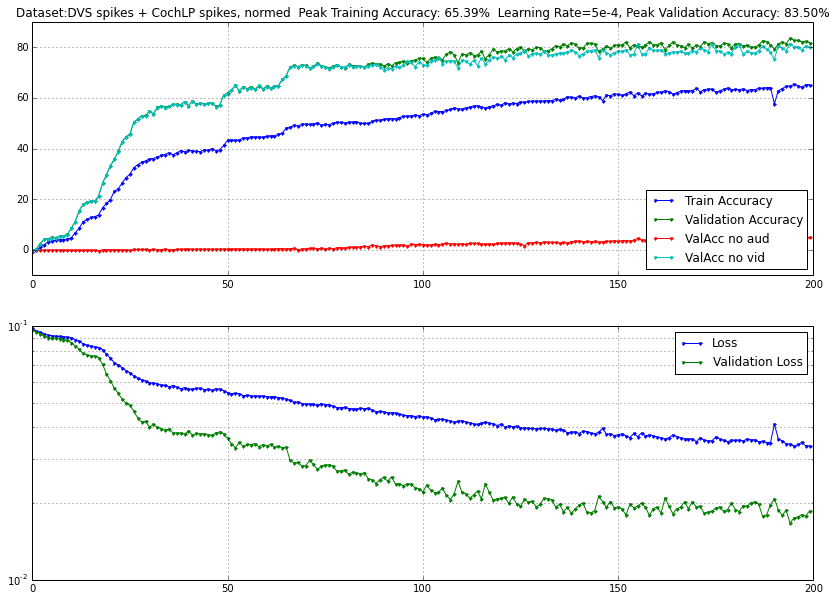

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sensors_ini.rnns.lasagne_utils import save_model, store_in_log, load_model, load_log, replace_updates_nans_with_zero
import lasagne
# One to investigate:
filename = 'lipreading_dvs_coch_shift_corr_1_recent'

# Load history from file
history = load_log(filename)

plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
plt.plot(history['train_acc'], '.-')
plt.plot(history['val_acc'], '.-')
val_no_aud_acc=[x*100 for x in history['val_no_aud_acc']]
val_no_vid_acc=[x*100 for x in history['val_no_vid_acc']]

train_no_aud_acc=[x*100 for x in history['train_no_aud_acc']]
train_no_vid_acc=[x*100 for x in history['train_no_vid_acc']]

plt.plot(val_no_aud_acc, '.-')
plt.plot(val_no_vid_acc, '.-')
#plt.plot(train_no_aud_acc, '.-')
#plt.plot(train_no_vid_acc, '.-')

#plt.legend(['Train Accuracy', 'Validation Accuracy','ValAcc no aud','ValAcc no vid','Train Acc no aud','Train Acc no vid'],loc=2)
#plt.legend(['Train Accuracy', 'Train Acc no aud','Train Acc no vid'],loc=2)
plt.legend(['Train Accuracy', 'Validation Accuracy','ValAcc no aud','ValAcc no vid'],loc='lower right')

#plt.legend(['Accuracy', 'Validation Accuracy'],loc='lower right')
plt.title('Dataset:DVS spikes + CochLP spikes, normed  Peak Training Accuracy: {:.2f}%  Learning Rate=5e-4, Peak Validation Accuracy: {:.2f}%'
          .format(  np.max(history['train_acc']),np.max(history['val_acc'])))
plt.grid(which='both')

plt.subplot(2,1,2)
plt.semilogy(history['train_err'], '.-')
plt.semilogy(history['val_err'], '.-')
plt.semilogy(history['val_no_aud_err'], '.-')
plt.semilogy(history['val_no_vid_err'], '.-')
plt.legend(['Loss', 'Validation Loss'])
plt.grid(which='both')
plt.savefig('grid_accuracy_history.png')
print(np.max(history['val_no_aud_acc']))
print(np.max(history['val_no_vid_acc']))
print(history['val_acc'][-1])

In [ ]:
import pickle
f = file('./models/grad_params')
grads_to_layer = pickle.load(f)
print(grads_to_layer)
f.close()

In [ ]:
np_grads = np.array(history['b_grads_normed'])
print(np_grads.shape)
plt.figure(figsize=(14,10))
for p_idx, grad_over_time in enumerate(np_grads.T):
    if grads_to_layer[p_idx] != -1:  
        l_idx, param_name = grads_to_layer[p_idx]
        if l_idx in [4,6]:
            plt.semilogy(grad_over_time, label='Layer: {}, Name: {}'.format(l_idx, param_name))
plt.grid(which='both')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('grads_by_param.png')

In [2]:
# Sum by layer
num_layers = 22#len(lasagne.layers.get_all_layers(network))
vid_layers=range(0,15)
aud_layers=range(15,17)

sum_by_layer = np.zeros( (3,np_grads.shape[0]) )
for p_idx, grad_over_time in enumerate(np_grads.T):
    if grads_to_layer[p_idx] != -1:        
        l_idx, param_name = grads_to_layer[p_idx]
        if l_idx in vid_layers:
            sum_by_layer[0, :] += grad_over_time
        elif l_idx in aud_layers:
            sum_by_layer[1, :] += grad_over_time 
        else:
            sum_by_layer[2, :] += grad_over_time
        
# Plot sum over layers
plt.figure(figsize=(14,8))
'''for l_idx, grad_over_time in enumerate(sum_by_layer):
    if np.any(grad_over_time > 0):
        plt.semilogy(grad_over_time, label='Layer: {}'.format(l_idx))
'''
#plt.semilogy(sum_by_layer[0,:],label='video')
#plt.semilogy(sum_by_layer[1,:],label='audio')
#plt.semilogy(sum_by_layer[2,:],label='post merge')
plt.plot(sum_by_layer[0,:],label='video')
plt.plot(sum_by_layer[1,:],label='audio')
plt.plot(sum_by_layer[2,:],label='post merge')

plt.grid(which='both')
plt.legend(loc='center')
#plt.cmap('gray')
plt.savefig('grads_by_layer.png')



NameError: name 'np_grads' is not defined

In [ ]:
## Sum by layer
num_layers = 22#len(lasagne.layers.get_all_layers(network))
vid_layers=range(0,15)
aud_layers=range(15,17)

sum_by_layer = np.zeros( (num_layers,np_grads.shape[0]) )
for p_idx, grad_over_time in enumerate(np_grads.T):
    if grads_to_layer[p_idx] != -1:        
        l_idx, param_name = grads_to_layer[p_idx]
        
        sum_by_layer[l_idx, :] += grad_over_time
        
# Plot sum over layers
plt.figure(figsize=(14,8))
for l_idx, grad_over_time in enumerate(sum_by_layer):
    if np.any(grad_over_time > 0):
        plt.semilogy(grad_over_time, label='Layer: {}'.format(l_idx))

#plt.semilogy(sum_by_layer[0,:],label='video')
#plt.semilogy(sum_by_layer[1,:],label='audio')
#plt.semilogy(sum_by_layer[2,:],label='post merge')
plt.grid(which='both')
plt.legend(loc='center')
#plt.cmap('gray')
plt.savefig('grads_by_layer.png')



In [4]:
import numpy as np
import theano.tensor as T
import theano
import glob
from lipreading_utils_grad import pad_sequences,find_data_mean, find_data_std, shift_test_iterator, HDF5LipReadingIterator_shift,HDF5LipReadingIterator_sep,ftensor5, get_train_and_val_fn, vocab_size, print_model
from lipreading_models import get_dan_original_rnn,get_network,get_network_12classes,get_dan_original_video,get_video_coch_net
import h5py

#h5file = '/media/yy/Seagate Expansion Drive1/hwGrid_20 (copy).hdf5'

h5file_video = '/media/yy/My Passport/lipread_data/grid_dvs_recap/DVS_40_on-off_normed3'
#h5file_coch='/media/yy/Seagate Expansion Drive1/grid_coch_recap/grid_coch_ctime_40_on.hdf5'
h5file_coch='/media/yy/My Passport/lipread_data/grid_coch_recap/grid_coch_ctime_40_on3_normed.hdf5'
#h5file='/media/yy/Seagate Expansion Drive1/coch_GridVideo1.hdf5'
#h5file='/home/yy/thesis/workspace/cochlp_6_17.hdf5'
# Get the same random data split
np.random.seed(42)   
# Get dataset
log = load_log(filename)

# Load dataset
dataset_coch=h5py.File(h5file_coch, "r")
dataset_dvs=h5py.File(h5file_video, "r")

print('Train set size: {} sentences.'.format(len(dataset_coch['train_labels'])))
print('Test set size: {} sentences.'.format(len(dataset_coch['test_labels'])))


# Load network

aud_in   = T.ftensor3('aud_in')
vid_in   = ftensor5('vid_in')
aud_mask = T.bmatrix('aud_mask')
#vid_in   = ftensor5('vid_in')
vid_mask = T.bmatrix('vid_mask')
targets  = T.fmatrix('targets')
network = get_video_coch_net(aud_in, vid_in)
load_model(filename, network)

# Get data iterator
d = HDF5LipReadingIterator_shift()
# Compile the output fn
print('Compiling output functions...')
train_fn, val_fn, out_fn = get_train_and_val_fn([aud_in, vid_in], targets, network)

#accuracy=get_network_output(vid_in, targets, network)

#acc_fn = theano.function([vid_in], accuracy)
print('Compiled.')

# Load a data
'''
for data in d.flow(dataset, 'test', batch_size=200, shuffle=False, blankout=0,audio_blankout_prob=0):
    
    aud_in, aud_mask, vid_in, vid_mask, bY =data
    output = out_fn(aud_in,vid_in)
    err, acc,debug_var2 = val_fn(aud_in,vid_in,  bY)
    no_aud_err, no_aud_acc,_= val_fn(aud_in*0., vid_in, bY)
    no_vid_err, no_vid_acc,_ = val_fn(aud_in, vid_in*0., bY)
    #err, acc,debug_var2 = val_fn(vid_in, bY)
    #ind, err2,acc2,test_pred_arr,test_prediction=val_fn2(vid_in,bY)
    #ind, ind_x, ind_y, test_pred_arr = val_fn2(vid_in)
    break
print('Data prepped and passed through.')'''
#print(acc)
#print(debug_var2)

Train set size: 19946 sentences.
Test set size: 2252 sentences.
Compiling output functions...
Compiled.


"\nfor data in d.flow(dataset, 'test', batch_size=200, shuffle=False, blankout=0,audio_blankout_prob=0):\n    \n    aud_in, aud_mask, vid_in, vid_mask, bY =data\n    output = out_fn(aud_in,vid_in)\n    err, acc,debug_var2 = val_fn(aud_in,vid_in,  bY)\n    no_aud_err, no_aud_acc,_= val_fn(aud_in*0., vid_in, bY)\n    no_vid_err, no_vid_acc,_ = val_fn(aud_in, vid_in*0., bY)\n    #err, acc,debug_var2 = val_fn(vid_in, bY)\n    #ind, err2,acc2,test_pred_arr,test_prediction=val_fn2(vid_in,bY)\n    #ind, ind_x, ind_y, test_pred_arr = val_fn2(vid_in)\n    break\nprint('Data prepped and passed through.')"

In [5]:
# Load a data
from lipreading_utils_grad import pad_sequences,find_data_mean, find_data_std, shift_test_iterator, HDF5LipReadingIterator_events,HDF5LipReadingIterator_sep,ftensor5, get_train_and_val_fn, vocab_size, print_model

for data in d.flow(dataset_dvs,dataset_coch, 'test', shifts_per_sample=10, batch_size=1,shuffle=False):

    aud_in, aud_mask, vid_in, vid_mask, bY =data
    output = out_fn(aud_in,vid_in)
    err, acc,debug_var2 = val_fn(aud_in,vid_in,  bY)
    no_aud_err, no_aud_acc,_= val_fn(aud_in*0., vid_in, bY)
    no_vid_err, no_vid_acc,_ = val_fn(aud_in, vid_in*0., bY)
    #err, acc,debug_var2 = val_fn(vid_in, bY)
    #ind, err2,acc2,test_pred_arr,test_prediction=val_fn2(vid_in,bY)
    #ind, ind_x, ind_y, test_pred_arr = val_fn2(vid_in)
    break
print('Data prepped and passed through.')

# Get data iterator
d2 = HDF5LipReadingIterator_sep()
for data in d2.flow(dataset_dvs,dataset_coch, 'test', batch_size=1,shuffle=False):

    aud_in2, aud_mask2, vid_in2, vid_mask2, bY2 =data
    output2 = out_fn(aud_in2,vid_in2)
    err, acc,debug_var2 = val_fn(aud_in2,vid_in2,  bY2)
    no_aud_err, no_aud_acc,_= val_fn(aud_in2*0., vid_in2, bY2)
    no_vid_err, no_vid_acc,_ = val_fn(aud_in2, vid_in2*0., bY2)
    #err, acc,debug_var2 = val_fn(vid_in, bY)
    #ind, err2,acc2,test_pred_arr,test_prediction=val_fn2(vid_in,bY)
    #ind, ind_x, ind_y, test_pred_arr = val_fn2(vid_in)
    break
print('Data prepped and passed through.')


Data prepped and passed through.
Data prepped and passed through.


775.542203128
77.5542186797
10


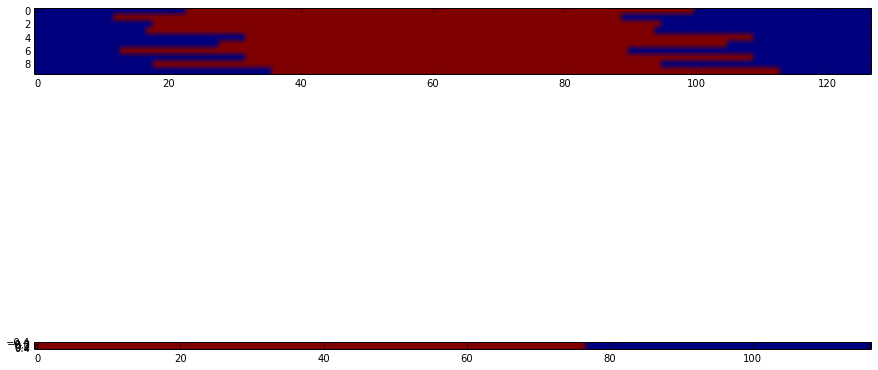

In [6]:
print(sum(sum(sum(aud_in))))
print(sum(sum(sum(aud_in2))))
plt.figure(figsize=[15,10])
plt.subplot(2,1,1)
plt.imshow(aud_mask)
plt.subplot(2,1,2)
plt.imshow(aud_mask2)
print(len(bY))

In [7]:
from lipreading_utils import bow_to_said_list
print(acc)
print(no_aud_err)
print(no_vid_err)
print(len(bY))
output_vid = out_fn(aud_in*0.,vid_in)
output_aud = out_fn(aud_in,vid_in*0.)
ind=3

print('Target: {}'.format(' '.join(bow_to_said_list(np.where(bY[ind]>0.5, 1, 0)))))
bow2=output2[-1][0]
print('Network guess, no shift: {}'.format(' '.join(bow_to_said_list(np.where(bow2>0.5, 1, 0)))))
for ind in range(10):
    bow = output[-1][ind]
    print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    #print('Network guess from audio: {}'.format(' '.join(bow_to_said_list(np.where(output_aud[-1][ind]>0.5, 1, 0)))))
    #print('Network guess from video: {}'.format(' '.join(bow_to_said_list(np.where(output_vid[-1][ind]>0.5, 1, 0)))))

0.5
0.0653320401907
0.107204936445
10
Target: bin blue with g 2 please
Network guess, no shift: bin blue with 2 again
Network guess: lay red with 2 now
Network guess: place blue with 2 now
Network guess: place blue with 2 now
Network guess: bin blue by with r 2 zero
Network guess: bin lay with 2 now
Network guess: lay blue with k 2 again
Network guess: place blue with 2 now
Network guess: lay green at zero now
Network guess: place green r 2 again
Network guess: bin red in 4 soon


In [ ]:
print(len(output))
print(output[0].shape)
print(output[15].shape)
print(np.mean(np.abs(output[14])))
print(np.mean(np.abs(output[16])))

In [ ]:
all_layers=lasagne.layers.get_all_layers(network)
print(len(all_layers))
plt.figure(figsize=[15,10])
plt.imshow(np.abs(all_layers[18].W_in_to_updategate.get_value()),interpolation='nearest',aspect='auto')
plt.colorbar()

w1=np.abs(all_layers[18].W_in_to_updategate.get_value())
print(w1.shape)
print(np.mean(w1[:80]))
print(np.mean(w1[80:]))


print(np.mean(w1[:80])*np.mean(np.abs(output[14])))
print(np.mean(w1[80:])*np.mean(np.abs(output[16])))

In [ ]:
print_model(network)

In [ ]:
aud_in, aud_mask, vid_in, vid_mask, bY =data

np.savez('/media/yy/Seagate Expansion Drive1/single_epoch.npy', aud_in, aud_mask, vid_in, vid_mask, bY)


In [ ]:
aud_in.shape

In [ ]:
print((sum(vid_in[1])))
print((vid_in.shape))

In [ ]:

np.sum(vid_in[1][-30])


In [ ]:
idx = 1


plt.figure(figsize=(16,4))
'''plt.subplot(1,2,1)
plt.imshow(aud_in[idx].T, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Audio input')

plt.subplot(1,2,2)
plt.imshow(aud_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Audio Mask')
'''
plt.figure(figsize=(16,8))
# Get padded max length
max_len = vid_in.shape[1]
for i in range(8):
    plt.subplot(2,4,i)
    plt.imshow(np.squeeze(vid_in[idx][i+20]), cmap='gray')
    plt.title('Frame: end-{}'.format(i))
    plt.colorbar()

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(vid_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Video Mask')

plt.subplot(1,2,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Targets')

In [ ]:
idx = 1


plt.figure(figsize=(16,4))
'''plt.subplot(1,2,1)
plt.imshow(aud_in[idx].T, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Audio input')

plt.subplot(1,2,2)
plt.imshow(aud_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Audio Mask')
'''
plt.figure(figsize=(16,8))
# Get padded max length
max_len = aud_in.shape[1]
for i in [-30,-29,-28]:
    plt.subplot(2,4,1)
    plt.imshow(np.squeeze(aud_in[idx][i]), cmap='gray')
    plt.title('Frame: end-{}'.format(i))
    plt.colorbar()

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(aud_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Video Mask')

plt.subplot(1,2,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Targets')

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(aud_mask, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('aud Mask')

In [ ]:
print_model_with_data(network, output)

In [ ]:
plt.figure(figsize=(4,4))
tmp=np.asarray(output[0])
tmp=tmp[0,1,0,:,:]
print(tmp.shape)
plt.imshow(np.squeeze(tmp))

plt.figure(figsize=(16,8))
for i in range(3,10):
    plt.subplot(3,3,i-3+1)
    plt.imshow(output[i][117][0], interpolation='nearest', cmap='gray')
    plt.colorbar()
    plt.title('Layer {}'.format(i))
#plt.savefig('face_through_layers.png')

In [ ]:
print_model(network)

In [ ]:
idx = 0
print(output[14].shape)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(output[14][idx].T, interpolation='nearest',aspect='auto')
#plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Video Features')
plt.subplot(1,2,2)
plt.imshow(output[16][idx].T, interpolation='nearest',aspect='auto')
#plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Audio Features')
#plt.savefig('merged_features.png')

In [ ]:
idx = 0
print(output[0][idx][0].shape)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(output[0][idx][70][0], interpolation='nearest',aspect='auto')
#plt.clim(-1,1)
plt.colorbar()
plt.title('Video Input')
plt.subplot(1,2,2)
plt.imshow(output[15][idx].T, interpolation='nearest',aspect='auto')
#plt.clim(-1,1)
plt.colorbar()
plt.title('Audio Input')
#plt.savefig('merged_features.png')

In [ ]:
idx = 2
print(output[19].shape)
plt.figure(figsize=(16,8))
plt.imshow(output[17][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('ConcatLayer')
#plt.savefig('merged_features.png')
idx = 0
print(output[19].shape)
plt.figure(figsize=(16,8))
plt.imshow(output[18][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Post-merge Features')
#plt.savefig('merged_features.png')
print(sum(sum(abs(output[18][idx]))))
print(sum(sum(abs(output[19][idx]))))

In [ ]:
idx = 0
print(output_vid[14].shape)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(output_vid[14][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Video Features')
plt.subplot(1,2,2)
plt.imshow(output_vid[16][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Audio Features')
#plt.savefig('merged_features.png')

In [ ]:
idx = 0
print(output_vid[19].shape)
plt.figure(figsize=(16,8))
plt.imshow(output_vid[17][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('ConcatLayer, video only')
#plt.savefig('merged_features.png')
idx = 0
print(output_vid[19].shape)
plt.figure(figsize=(16,8))
plt.imshow(output_vid[18][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Post-merge Features, video only')
#plt.savefig('merged_features.png')
print(sum(sum(abs(output_vid[18][idx]))))
print(sum(sum(abs(output_vid[19][idx]))))

In [ ]:
idx = 0
print(output_aud[14].shape)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(output_aud[14][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Video Features')
plt.subplot(1,2,2)
plt.imshow(output_aud[16][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Audio Features')
#plt.savefig('merged_features.png')

In [ ]:
idx = 0
print(output_aud[17].shape)
plt.figure(figsize=(16,8))
plt.imshow(output_aud[17][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('ConCatLayer,audio only')
#plt.savefig('merged_features.png')
idx = 0
print(output_aud[19].shape)
plt.figure(figsize=(16,8))
plt.imshow(output_aud[19][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Post-merge Features,audio only')
#plt.savefig('merged_features.png')
print(sum(sum(abs(output_aud[18][idx]))))
print(sum(sum(abs(output_aud[19][idx]))))

In [ ]:
output_zero = out_fn(aud_in*0.,vid_in*0)

In [ ]:
idx = 0
print(output_zero[14].shape)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(output_zero[14][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Video Features')
plt.subplot(1,2,2)
plt.imshow(output_zero[16][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Pre-merge Audio Features')
#plt.savefig('merged_features.png')

In [ ]:
idx = 0
print(output_zero[19].shape)
plt.figure(figsize=(16,8))
plt.imshow(output_zero[19][idx].T, interpolation='nearest',aspect='auto')
plt.clim(-1,1)
plt.colorbar()
plt.title('Post-merge Features')
#plt.savefig('merged_features.png')

In [ ]:
from lipreading_utils import bow_to_said_list
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.imshow(output_aud[-1], interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Guesses')
plt.ylabel('Example Idx')
plt.subplot(2,1,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('True Answer')
plt.ylabel('Example Idx')
plt.xlabel('Word')
plt.title('video only')
for idx in range(10):
    # Extract bag-of-words of interest
    bow = output_aud[-1][idx]
    # Find the chosen words
    print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    #print('Network guess: {}'.format(' '.join(bow_to_said_list(test_pred_arr[idx]))))
    
    print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #print(bY[idx])
    #plt.savefig('network_guesses.png')

In [ ]:
def get_pred_category(net_output):
    num_cate=6
    #number of words in each category
    '''
    commands = ['bin', 'lay', 'place', 'set']
    colors = ['blue', 'green', 'red', 'white']
    prepositions = ['at','by','in','with']
    letters = list(set(map(chr, range(ord('a'), ord('z')+1))) - set('w'))
    digits = [str(i) for i in range(1,10)] + ['zero']
    adverbs = ['again','now','please','soon']'''
    starting_ind=[0,4,8,12,37,47]
    num_words=[4,4,4,25,10,4]
    pred=np.zeros_like(net_output)
    for sample_cnt in range(net_output.shape[0]):
        for i in range(num_cate):
            pred_ind=np.argmax(net_output[sample_cnt][starting_ind[i]:starting_ind[i]+num_words[i]])
            #print(pred_ind)
            pred[sample_cnt][pred_ind+starting_ind[i]]=1
            
    return pred

In [ ]:
pred_cate=get_pred_category(test_prediction)

from lipreading_utils import bow_to_said_list
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.imshow(output[-1], interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Guesses')
plt.ylabel('Example Idx')
plt.subplot(2,1,2)
plt.imshow(bY, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('True Answer')
plt.ylabel('Example Idx')
plt.xlabel('Word')

for idx in range(7):
    # Extract bag-of-words of interest
    bow = output[-1][idx]
    # Find the chosen words
    print('Network guess: {}'.format(' '.join(bow_to_said_list(pred_cate[idx]))))
    print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #print(bY[idx])
    #plt.savefig('network_guesses.png')

In [ ]:
bow = output[-1][0]
target_var=bY[0]
print(bow)
test_prediction_thresholded = np.where(output[-1]>0.5, 1.0, 0.0)
print(test_prediction_thresholded)
sum_of_targets = np.sum(bY,axis=1)
test_mean_mismatch_per_example = np.sum(abs(test_prediction_thresholded-bY), axis=1)/sum_of_targets
test_acc = 1.-np.mean(test_mean_mismatch_per_example)
print(test_acc)

In [ ]:
print(len(output[0][0]))

In [ ]:
#confusion matrix
#testing
from lipreading_utils import bow_to_said_list

plt.figure(figsize=(16,16))
con_mat_train=np.zeros([51, 51])
for idx in range(51):
    # Extract bag-of-words of interest
    bow = output[-1][idx]
    # Find the chosen words
    #print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    #print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #plt.savefig('network_guesses.png')
    pred=np.where(bow>0.5, 1, 0)
    label=bY[idx]
    #print(pred)
    #print(label)
    pred_ind=np.where(pred==1)
    label_ind=np.where(label==1)
    #print(pred_ind[0])
    #print(len(pred_ind[0])-1)
    #print(len(label_ind[0])-1)
    
    for i in range(min(len(pred_ind[0])-1,len(label_ind[0])-1)):
        
        con_mat_train[pred_ind[0][i]][label_ind[0][i]]=con_mat_train[pred_ind[0][i]][label_ind[0][i]]+1

plt.imshow(con_mat_train, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Testing')    

In [ ]:
len(pred_ind[0])

In [ ]:
#confusion matrix
#testing
from lipreading_utils import bow_to_said_list

plt.figure(figsize=(16,16))
con_mat_train=np.zeros([51, 51])
for idx in range(200):
    # Extract bag-of-words of interest
    bow = output[-1][idx]
    # Find the chosen words
    #print('Network guess: {}'.format(' '.join(bow_to_said_list(np.where(bow>0.5, 1, 0)))))
    #print('True: {}'.format(' '.join(bow_to_said_list(bY[idx]))))
    #plt.savefig('network_guesses.png')
    pred=np.where(bow>0.5, 1, 0)
    label=bY[idx]
    #print(pred)
    #print(label)
    pred_ind=np.where(pred==1)
    label_ind=np.where(label==1)
    #print(pred_ind[0])
    #print(len(pred_ind[0])-1)
    #print(len(label_ind[0])-1)
    
    for i in range(min(len(pred_ind[0])-1,len(label_ind[0])-1)):
        
        con_mat_train[pred_ind[0][i]][label_ind[0][i]]=con_mat_train[pred_ind[0][i]][label_ind[0][i]]+1

plt.imshow(con_mat_train, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.title('Testing, video only')    